<a href="https://colab.research.google.com/github/CSID-DGU/2024-02-CSC4004-1-1-BabsangLab/blob/ai-model/Food101ClassifiactionModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
$import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d dansbecker/food-101

Dataset URL: https://www.kaggle.com/datasets/dansbecker/food-101
License(s): other
100% 9.35G/9.38G [00:54<00:00, 137MB/s]
100% 9.38G/9.38G [00:54<00:00, 184MB/s]


In [ ]:
!unzip food-101.zip -d /content/food-101

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/food-101/food-101/food-101/images/tacos/1030289.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1033196.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1036030.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1042175.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1044043.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1058697.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1059239.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1059326.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1066762.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1070967.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1073468.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1075296.jpg  
  inflating: /content/food-101/food-101/food-101/ima

In [ ]:
import os
import random
import pandas as pd
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
from tensorflow.keras.metrics import top_k_categorical_accuracy

K.clear_session()

# 데이터셋의 10%만 사용하기 위한 설정 (이 중 90%는 학습용, 10%는 검증용)
all_image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk('/content/food-101/food-101/food-101/images') for f in filenames if f.endswith(".jpg")]
sampled_image_paths = random.sample(all_image_paths, int(len(all_image_paths) * 0.1))
data = pd.DataFrame({'filename': sampled_image_paths, 'class': [os.path.basename(os.path.dirname(path)) for path in sampled_image_paths]})
train_data = data.sample(frac=0.9, random_state=42)
val_data = data.drop(train_data.index)

# 데이터 증강 및 ImageDataGenerator 생성
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),  # MobileNetV2의 기본 입력 크기
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(7, 7))(x)  # MobileNetV2의 마지막 풀링 레이어 크기
x = Dropout(0.4)(x)
x = Flatten()(x)
predictions = Dense(101, kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.0005), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


def schedule(epoch):
    if epoch < 15:
        return 0.01
    elif epoch < 28:
        return 0.002
    else:
        return 0.0004

# top-5 accuracy 정의
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

# 모델 컴파일
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', top_5_accuracy])

# 모델 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=32,
    verbose=1,
)

# 학습된 모델 저장
model.save('/content/drive/MyDrive/model_trained_mobilenetv2_food101.h5')

Found 9090 validated image filenames belonging to 101 classes.
Found 1010 validated image filenames belonging to 101 classes.


<ipython-input-14-613ca90bddb5>:56: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


Epoch 1/32


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/285 ━━━━━━━━━━━━━━━━━━━━ 192s 533ms/step - accuracy: 0.0524 - loss: 4.5493 - top_5_accuracy: 0.1657 - val_accuracy: 0.0099 - val_loss: 11.1262 - val_top_5_accuracy: 0.0525
Epoch 2/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 126s 432ms/step - accuracy: 0.2066 - loss: 3.4600 - top_5_accuracy: 0.4687 - val_accuracy: 0.0099 - val_loss: 14.0076 - val_top_5_accuracy: 0.0574
Epoch 3/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 126s 430ms/step - accuracy: 0.3093 - loss: 2.8764 - top_5_accuracy: 0.6141 - val_accuracy: 0.0168 - val_loss: 13.7015 - val_top_5_accuracy: 0.0584
Epoch 4/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 127s 435ms/step - accuracy: 0.3931 - loss: 2.5187 - top_5_accuracy: 0.6947 - val_accuracy: 0.0139 - val_loss: 13.5015 - val_top_5_accuracy: 0.0693
Epoch 5/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 127s 433ms/step - accuracy: 0.4432 - loss: 2.2731 - top_5_accuracy: 0.7445 - val_accuracy: 0.0248 - val_loss: 11.6533 - val_top_5_accuracy: 0.0802
Epoch 6/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 126s 432ms/step - accuracy: 0.4850 -

In [ ]:
import os
import random
import pandas as pd
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
from tensorflow.keras.metrics import top_k_categorical_accuracy

K.clear_session()

# 데이터셋의 10%만 사용하기 위한 설정 (이 중 90%는 학습용, 10%는 검증용)
all_image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk('/content/food-101/food-101/food-101/images') for f in filenames if f.endswith(".jpg")]
sampled_image_paths = random.sample(all_image_paths, int(len(all_image_paths) * 0.1))
data = pd.DataFrame({'filename': sampled_image_paths, 'class': [os.path.basename(os.path.dirname(path)) for path in sampled_image_paths]})
train_data = data.sample(frac=0.9, random_state=42)
val_data = data.drop(train_data.index)

# 데이터 증강 및 ImageDataGenerator 생성
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),  # ResNet50의 기본 입력 크기
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# ResNet50 모델 불러오기
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
predictions = Dense(101, kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.0005), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

def schedule(epoch):
    if epoch < 15:
        return 0.01
    elif epoch < 28:
        return 0.002
    else:
        return 0.0004

# top-5 accuracy 정의
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

# 모델 컴파일
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', top_5_accuracy])

# 모델 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=32,
    verbose=1,
)

# 학습된 모델 저장
model.save('/content/drive/MyDrive/model_trained_resnet50_food101.h5')

Found 9090 validated image filenames belonging to 101 classes.
Found 1010 validated image filenames belonging to 101 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/32


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/285 ━━━━━━━━━━━━━━━━━━━━ 201s 543ms/step - accuracy: 0.0886 - loss: 4.4811 - top_5_accuracy: 0.2209 - val_accuracy: 0.0129 - val_loss: 5.3412 - val_top_5_accuracy: 0.0594
Epoch 2/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 127s 435ms/step - accuracy: 0.3301 - loss: 2.8558 - top_5_accuracy: 0.6162 - val_accuracy: 0.0208 - val_loss: 5.2561 - val_top_5_accuracy: 0.0644
Epoch 3/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 127s 434ms/step - accuracy: 0.4496 - loss: 2.2873 - top_5_accuracy: 0.7415 - val_accuracy: 0.1188 - val_loss: 4.4078 - val_top_5_accuracy: 0.3149
Epoch 4/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 127s 435ms/step - accuracy: 0.5169 - loss: 2.0149 - top_5_accuracy: 0.7952 - val_accuracy: 0.3069 - val_loss: 3.2757 - val_top_5_accuracy: 0.5822
Epoch 5/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 126s 432ms/step - accuracy: 0.5792 - loss: 1.7378 - top_5_accuracy: 0.8398 - val_accuracy: 0.3386 - val_loss: 2.9564 - val_top_5_accuracy: 0.6198
Epoch 6/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 127s 436ms/step - accuracy: 0.6154 - loss

In [ ]:
import os
import random
import pandas as pd
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
from tensorflow.keras.metrics import top_k_categorical_accuracy

K.clear_session()

# 데이터셋의 10%만 사용하기 위한 설정 (이 중 90%는 학습용, 10%는 검증용)
all_image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk('/content/food-101/food-101/food-101/images') for f in filenames if f.endswith(".jpg")]
sampled_image_paths = random.sample(all_image_paths, int(len(all_image_paths) * 0.1))
data = pd.DataFrame({'filename': sampled_image_paths, 'class': [os.path.basename(os.path.dirname(path)) for path in sampled_image_paths]})
train_data = data.sample(frac=0.9, random_state=42)
val_data = data.drop(train_data.index)

# 데이터 증강 및 ImageDataGenerator 생성
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col="filename",
    y_col="class",
    target_size=(299, 299),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col="filename",
    y_col="class",
    target_size=(299, 299),
    batch_size=32,
    class_mode="categorical"
)

# InceptionV3 모델 불러오기
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
predictions = Dense(101, kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.0005), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

def schedule(epoch):
    if epoch < 15:
        return 0.01
    elif epoch < 28:
        return 0.002
    else:
        return 0.0004

# top-5 accuracy정의
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

# 모델 컴파일
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', top_5_accuracy])

# 모델 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=32,
    verbose=1,
)

# 학습된 모델 저장
model.save('/content/drive/MyDrive/model_trained_inceptionv3_food101.h5')

Found 9090 validated image filenames belonging to 101 classes.
Found 1010 validated image filenames belonging to 101 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/32


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/285 ━━━━━━━━━━━━━━━━━━━━ 317s 875ms/step - accuracy: 0.1368 - loss: 4.0466 - top_5_accuracy: 0.3160 - val_accuracy: 0.1366 - val_loss: 4.6538 - val_top_5_accuracy: 0.3277
Epoch 2/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 211s 723ms/step - accuracy: 0.4310 - loss: 2.3783 - top_5_accuracy: 0.7220 - val_accuracy: 0.2545 - val_loss: 3.8254 - val_top_5_accuracy: 0.5109
Epoch 3/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 212s 725ms/step - accuracy: 0.5560 - loss: 1.8154 - top_5_accuracy: 0.8282 - val_accuracy: 0.2901 - val_loss: 3.5591 - val_top_5_accuracy: 0.5723
Epoch 4/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 212s 726ms/step - accuracy: 0.6389 - loss: 1.4794 - top_5_accuracy: 0.8790 - val_accuracy: 0.3426 - val_loss: 3.5054 - val_top_5_accuracy: 0.6119
Epoch 5/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 210s 719ms/step - accuracy: 0.6597 - loss: 1.3835 - top_5_accuracy: 0.8928 - val_accuracy: 0.3950 - val_loss: 3.0226 - val_top_5_accuracy: 0.6693
Epoch 6/32
285/285 ━━━━━━━━━━━━━━━━━━━━ 212s 725ms/step - accuracy: 0.7332 - loss

Predictions for /content/drive/MyDrive/bibimbab.jpeg:


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


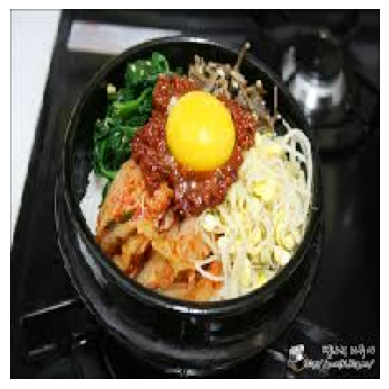

Top 5 Predictions:
1: bibimbap (55.81%)
2: spaghetti_bolognese (22.37%)
3: spaghetti_carbonara (9.83%)
4: ramen (7.90%)
5: beef_tartare (2.62%)


Predictions for /content/drive/MyDrive/omelet.jpeg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


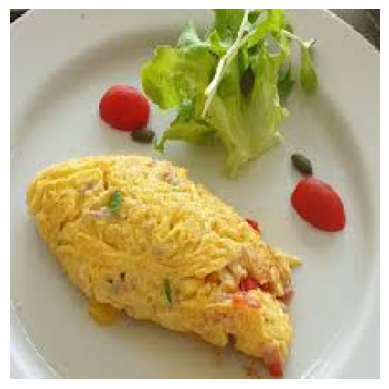

Top 5 Predictions:
1: chocolate_cake (38.98%)
2: pad_thai (14.25%)
3: spaghetti_bolognese (12.04%)
4: chocolate_mousse (9.36%)
5: tiramisu (5.72%)


Predictions for /content/drive/MyDrive/miso_soup.jpeg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


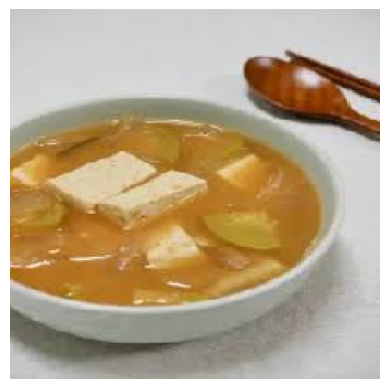

Top 5 Predictions:
1: ravioli (80.02%)
2: lobster_bisque (7.12%)
3: gnocchi (4.88%)
4: shrimp_and_grits (3.88%)
5: chicken_curry (2.32%)




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.metrics import top_k_categorical_accuracy

# 학습된 모델 로드
model = load_model('/content/drive/MyDrive/model_trained_mobilenetv2_food101.h5', custom_objects={'top_5_accuracy': top_k_categorical_accuracy})

def predict_image(image_path):
    # 이미지 로드 및 전처리
    img = load_img(image_path, target_size=(224, 224))  # MobileNetV2의 입력 크기에 맞춤
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # MobileNetV2에 맞춘 전처리

    # 모델 예측 수행
    preds = model.predict(img_array)

    # 상위 5개 예측
    top_5_indices = np.argsort(preds[0])[-5:][::-1]  # 상위 5개 클래스 인덱스
    top_5_probs = preds[0][top_5_indices]

    # 이미지와 예측 결과 표시
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # 상위 5개 예측과 확률 출력
    print("Top 5 Predictions:")
    for i, (index, prob) in enumerate(zip(top_5_indices, top_5_probs)):
        class_name = class_labels[index]
        print(f"{i+1}: {class_name} ({prob * 100:.2f}%)")

# 클래스 레이블 로드
class_labels = pd.read_csv('/content/food-101/food-101/food-101/meta/classes.txt', header=None).iloc[:,0].tolist()

# 테스트 이미지 목록 설정
test_images = [
    '/content/drive/MyDrive/bibimbab.jpeg',
    '/content/drive/MyDrive/omelet.jpeg',
    '/content/drive/MyDrive/miso_soup.jpeg'
]

# 예측 수행 및 결과 표시
for image_path in test_images:
    print(f"Predictions for {image_path}:")
    predict_image(image_path)
    print("\n" + "="*50 + "\n")


Predictions for /content/drive/MyDrive/bibimbab.jpeg:


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


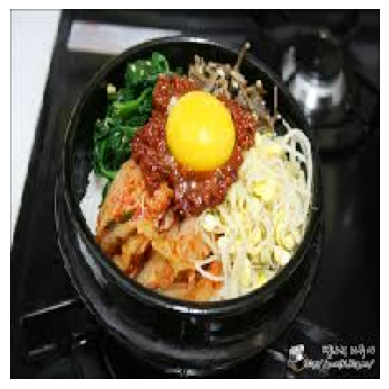

Top 5 Predictions:
1: baby_back_ribs (99.78%)
2: tiramisu (0.15%)
3: filet_mignon (0.06%)
4: ceviche (0.00%)
5: beet_salad (0.00%)


Predictions for /content/drive/MyDrive/omelet.jpeg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


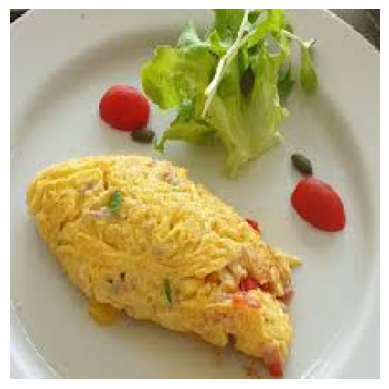

Top 5 Predictions:
1: baby_back_ribs (96.37%)
2: ceviche (2.37%)
3: seaweed_salad (0.36%)
4: edamame (0.26%)
5: beet_salad (0.13%)


Predictions for /content/drive/MyDrive/miso_soup.jpeg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


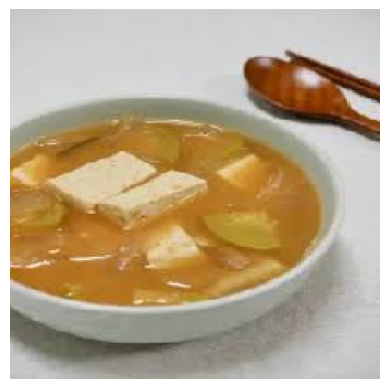

Top 5 Predictions:
1: chicken_curry (42.81%)
2: baby_back_ribs (24.77%)
3: chocolate_cake (14.94%)
4: bibimbap (4.22%)
5: grilled_salmon (1.88%)




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.metrics import top_k_categorical_accuracy

# 학습된 모델 로드
model = load_model('/content/drive/MyDrive/model_trained_resnet50_food101.h5', custom_objects={'top_5_accuracy': top_k_categorical_accuracy})

def predict_image(image_path):
    # 이미지 로드 및 전처리
    img = load_img(image_path, target_size=(224, 224))  # MobileNetV2의 입력 크기에 맞춤
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # MobileNetV2에 맞춘 전처리

    # 모델 예측 수행
    preds = model.predict(img_array)

    # 상위 5개 예측
    top_5_indices = np.argsort(preds[0])[-5:][::-1]  # 상위 5개 클래스 인덱스
    top_5_probs = preds[0][top_5_indices]

    # 이미지와 예측 결과 표시
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # 상위 5개 예측과 확률 출력
    print("Top 5 Predictions:")
    for i, (index, prob) in enumerate(zip(top_5_indices, top_5_probs)):
        class_name = class_labels[index]  # 인덱스를 클래스 이름으로 변환
        print(f"{i+1}: {class_name} ({prob * 100:.2f}%)")

# 클래스 레이블 로드
class_labels = pd.read_csv('/content/food-101/food-101/food-101/meta/classes.txt', header=None).iloc[:,0].tolist()

# 테스트 이미지 목록 설정
test_images = [
    '/content/drive/MyDrive/bibimbab.jpeg',
    '/content/drive/MyDrive/omelet.jpeg',
    '/content/drive/MyDrive/miso_soup.jpeg'
]

# 예측 수행 및 결과 표시
for image_path in test_images:
    print(f"Predictions for {image_path}:")
    predict_image(image_path)
    print("\n" + "="*50 + "\n")


Predictions for /content/drive/MyDrive/bibimbab.jpeg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


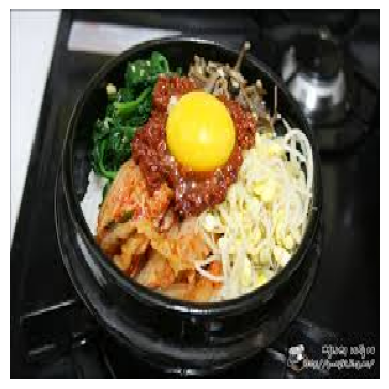

Top 5 Predictions:
1: bibimbap (49.32%)
2: chocolate_cake (15.72%)
3: waffles (7.69%)
4: seaweed_salad (6.91%)
5: grilled_salmon (2.41%)


Predictions for /content/drive/MyDrive/omelet.jpeg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


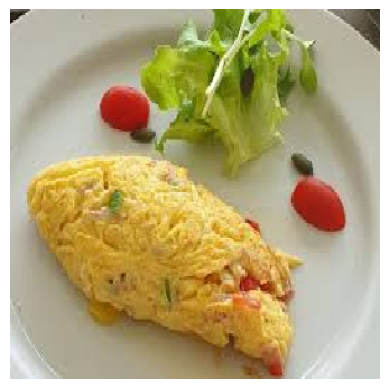

Top 5 Predictions:
1: omelette (92.89%)
2: baklava (2.31%)
3: waffles (1.24%)
4: french_toast (0.96%)
5: greek_salad (0.46%)


Predictions for /content/drive/MyDrive/miso_soup.jpeg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


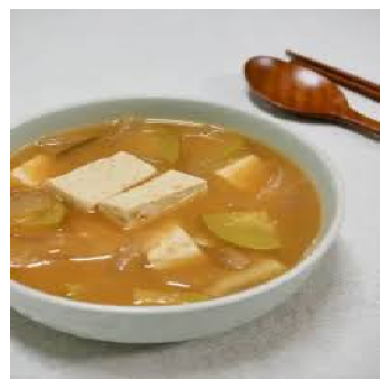

Top 5 Predictions:
1: hot_and_sour_soup (88.45%)
2: ramen (5.02%)
3: miso_soup (2.64%)
4: chicken_curry (0.70%)
5: waffles (0.41%)




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.metrics import top_k_categorical_accuracy

# 학습된 모델 로드 (InceptionV3)
model = load_model('/content/drive/MyDrive/model_trained_inceptionv3_food101.h5', custom_objects={'top_5_accuracy': top_k_categorical_accuracy})

def predict_image(image_path):
    # 이미지 로드 및 전처리
    img = load_img(image_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # InceptionV3에 맞춘 전처리

    # 모델 예측 수행
    preds = model.predict(img_array)

    # 상위 5개 예측
    top_5_indices = np.argsort(preds[0])[-5:][::-1]  # 상위 5개 클래스 인덱스
    top_5_probs = preds[0][top_5_indices]

    # 이미지와 예측 결과 표시
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # 상위 5개 예측과 확률 출력
    print("Top 5 Predictions:")
    for i, (index, prob) in enumerate(zip(top_5_indices, top_5_probs)):
        class_name = class_labels[index]  # 인덱스를 클래스 이름으로 변환
        print(f"{i+1}: {class_name} ({prob * 100:.2f}%)")

# 클래스 레이블 로드
class_labels = pd.read_csv('/content/food-101/food-101/food-101/meta/classes.txt', header=None).iloc[:,0].tolist()

# 테스트 이미지 목록 설정
test_images = [
    '/content/drive/MyDrive/bibimbab.jpeg',
    '/content/drive/MyDrive/omelet.jpeg',
    '/content/drive/MyDrive/miso_soup.jpeg'
]

# 예측 수행 및 결과 표시
for image_path in test_images:
    print(f"Predictions for {image_path}:")
    predict_image(image_path)
    print("\n" + "="*50 + "\n")
